In [171]:
## need packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from datetime import datetime, timedelta 
import statsmodels
import operator
import os
import tqdm

colors = ['#34495e','#2ecc71','#3498db','#FFFF00', '#e74c3c','#a9a9a9']
s_list = pd.date_range(pd.to_datetime('2018-05-01', format='%Y-%m-%d %H:%M:%S.%f'), periods=31).tolist()
e_list = pd.date_range(pd.to_datetime('2018-05-02', format='%Y-%m-%d %H:%M:%S.%f'), periods=31).tolist()
sns.set(style="ticks", color_codes=True)
%matplotlib inline

In [229]:
os.system("taskset -p 0xffffffff %d"% os.getpid())

256

In [2]:
## configuration for filepath
filepath   = '../data/'
filename01 = 'merged_data_wo_ffill.csv'
outputpath = '../graph/mid/objective_2/'

In [3]:
## data type for sensing data
data_types = {'dev_id': np.string_,
'dev_dt': np.string_,
'pm25': np.string_,
'pm10': np.string_,
'voc_ref': np.string_,
'voc_now': np.string_,
'humi': np.string_,
'temp': np.string_,
'lux': np.string_,
'co2': np.string_,
'pm10_idx': np.string_,
'pm25_idx': np.string_,
'vocs_idx': np.string_,
'co2_idx': np.string_,
'iaq_idx': np.string_,
'unpl_idx': np.string_,
'polt_idx': np.string_,
'dt': np.string_,
'invnr': np.string_,
'inbdt': np.string_,
'use_cust_id': np.string_,
'pyn': np.string_,
'room_cnt': np.string_,
'do_nm': np.string_,
'ct_nm': np.string_,
'gu_nm': np.string_,
'dng_nm': np.string_,
'apts_in_date': np.string_,
'bldg_tp': np.string_,
'rtn_conf_dt': np.string_,
'age': np.string_,
'sex': np.string_,
'cust_tpnm': np.string_}

In [4]:
%%time
## data load
data   = pd.read_csv(filepath + filename01, parse_dates=['dev_dt', 'apts_in_date', 'dt_x', 'dt_y', 'invnr'])

<string>:2: DtypeWarning: Columns (25,28) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 7min 33s, sys: 25.3 s, total: 7min 59s
Wall time: 7min 59s


## case I definition
- 새벽시간(0시~6시)
- 정음모드(mode_stng = 2)
- pm10 >= bad (80) 의 비율이 20% 이상인 날이 31일 기준의 10일 이상
- specific device('17202D8F1732300091', dawn data mean, std) 15 16 21 22 26

In [604]:
target_ffill = ['pwr_stng', 'mode_stng', 'fan_speed_adj', 'light_stng', 'eco_mode_stng', 'oaq_idx']

In [19]:
selected_devices = data['dev_id'].unique()
selected_devices.sort

<function ndarray.sort>

In [20]:
len(selected_devices)

1863

In [416]:
%%time
data.loc[(data['mode_stng'] == 0) & (data['fan_speed_adj'] == 0),  ['fan_speed_adj']] = np.nan
data.loc[data['mode_stng'] == 2, ['fan_speed_adj']] = 0.5
data.loc[data['mode_stng'] == 4, ['fan_speed_adj']] = 0
data.loc[data['mode_stng'] == 5, ['fan_speed_adj']] = 3

CPU times: user 2.09 s, sys: 992 ms, total: 3.08 s
Wall time: 3.08 s


In [ ]:
pd.fillna()

In [417]:
%%time
device_data = [data[data['dev_id'] == name] for name in selected_devices]
[device_data[n].reset_index(inplace=True) for n in range(len(selected_devices))]
[device_data[n].drop('index', axis=1, inplace=True) for n in range(len(selected_devices))]
[device_data[n][name].fillna(method='ffill', inplace=True) for n in range(len(selected_devices)) for name in target_ffill]
[device_data[n]['ventil_alrm'].fillna(value=0, inplace=True) for n in range(len(selected_devices)) for name in target_ffill]

/home/data/roki/.virtualenvs/coway_cp36/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/data/roki/.virtualenvs/coway_cp36/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


CPU times: user 8h 33min 15s, sys: 34.6 s, total: 8h 33min 50s
Wall time: 8h 33min 43s


In [418]:
%%time
for i in range(len(device_data)):
    device_data[i]['day'] = pd.DatetimeIndex(device_data[i]['dev_dt']).day

/home/data/roki/.virtualenvs/coway_cp36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 16min 38s, sys: 64 ms, total: 16min 38s
Wall time: 16min 38s


In [419]:
det = lambda t, d: t.between(d, d + pd.Timedelta(6, unit='h'), inclusive=True)

In [420]:
%%time
cut_device_data = [device_data[n][det(device_data[n]['dev_dt'], date)] for n in range(len(selected_devices)) for date in pd.date_range('2018-05-01', periods=31).tolist()]

CPU times: user 1min 49s, sys: 0 ns, total: 1min 49s
Wall time: 1min 49s


In [421]:
names = [device_data[n]['dev_id'].unique() for n in range(len(device_data))]

In [423]:
np.where(np.isin(names, '17202D8F1732300091'))

(array([968]), array([0]))

In [224]:
device_data[968]['dev_id'].unique()

array(['17202D8F1732300091'], dtype=object)

In [400]:
len(selected_devices)

1863

In [424]:
%%time
processed_dawn_data = pd.concat(cut_device_data, axis=0, ignore_index=True)

CPU times: user 1min 18s, sys: 2.31 s, total: 1min 20s
Wall time: 1min 19s


In [432]:
%%time
processed_dawn_data.to_csv(filepath + 'processed_dawn_data.csv', index=False)

CPU times: user 9min 59s, sys: 4.38 s, total: 10min 3s
Wall time: 10min 3s


In [425]:
%%time
processed_whole_data = pd.concat(device_data, axis=0, ignore_index=True)

CPU times: user 19.3 s, sys: 5.31 s, total: 24.6 s
Wall time: 24.6 s


In [430]:
%%time
processed_whole_data.to_csv(filepath + 'processed_whole_data.csv', index=False)

CPU times: user 40min 36s, sys: 18.9 s, total: 40min 54s
Wall time: 40min 55s


In [266]:
det_pm10_grade = lambda d: 1 if d >= 80 else 0

In [273]:
%%time
processed_dawn_data['pm10_grade'] = [det_pm10_grade(p) for p in processed_dawn_data['pm10']]

CPU times: user 4.89 s, sys: 236 ms, total: 5.12 s
Wall time: 5.12 s


In [276]:
%%time
slient_mode_device_data = processed_dawn_data.loc[processed_dawn_data['mode_stng'] == 2, :]

CPU times: user 1.13 s, sys: 696 ms, total: 1.82 s
Wall time: 1.83 s


In [245]:
yun_device = slient_mode_device_data[slient_mode_device_data['dev_id'] == '17202D8F1732300091']

In [250]:
yum_result = yun_device[yun_device['dev_dt'].between('2018-05-21 00:00', '2018-05-21 06:00', inclusive = True)]

In [120]:
# %%time
# cut_slient_data = slient_mode_device_data.loc[slient_mode_device_data['pm10'] >= 80, :]

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 90.7 ms


## basis devices

- ['dev_id'] == '17202D8F1732300091'

In [341]:
%%time
result_01 = processed_dawn_data.groupby(['dev_id', 'day'])['pm10_grade'].sum()
result_02 = processed_dawn_data.groupby(['dev_id', 'day'])['pm10_grade'].describe()['count']

CPU times: user 1min 16s, sys: 1.14 s, total: 1min 17s
Wall time: 1min 17s


In [354]:
result_01 = result_01.reset_index()
result_02 = result_02.reset_index()

In [358]:
result = pd.concat([result_01, result_02['count']], axis=1)

In [360]:
result['ratio'] = result['pm10_grade'] / result['count']

In [404]:
result['isRight'] = [g >= 0.15 for g in result['ratio']]

## much case
16102D8F15B2000163
## less case
16202D8F15C0400051
## ambigious
17102D8F1633000076

In [412]:
result[result['dev_id'] == '17202D8F1732300091']

,dev_id,day,pm10_grade,count,ratio,isRight
24428,17202D8F1732300091,1,227,361.0,0.628809,True
24429,17202D8F1732300091,2,330,362.0,0.911602,True
24430,17202D8F1732300091,3,108,362.0,0.298343,True
24431,17202D8F1732300091,4,107,364.0,0.293956,True
24432,17202D8F1732300091,5,159,362.0,0.439227,True
24433,17202D8F1732300091,6,205,362.0,0.566298,True
24434,17202D8F1732300091,7,104,362.0,0.287293,True
24435,17202D8F1732300091,8,110,361.0,0.304709,True
24436,17202D8F1732300091,9,25,363.0,0.068871,False
24437,17202D8F1732300091,10,26,362.0,0.071823,False


In [413]:
result_devices = result.groupby('dev_id')['isRight'].sum().reset_index()

In [414]:
len(result_devices[result_devices['isRight'] >= 7]) / len(selected_devices)

0.06333870101986044

In [143]:
dawn_devies = slient_mode_device_data['dev_id'].unique()

In [265]:
det_devices = lambda d: 1 if d in dawn_devies else 0

In [198]:
%%time
case_I_result['slient'] = [det_devices(case_I_result.loc[n, 'dev_id']) for n in range(len(case_I_result))]

CPU times: user 3.44 s, sys: 140 ms, total: 3.58 s
Wall time: 3.46 s


In [188]:
%%time
case_I_result_dev['slient'] = [det_devices(case_I_result_dev.loc[n, 'dev_id']) for n in range(len(case_I_result_dev))]

CPU times: user 488 ms, sys: 8 ms, total: 496 ms
Wall time: 487 ms


## case II definition
- pm10이 특정값 들로만 센싱되는 경우

In [500]:
test = device_data[0].groupby(['day', 'pm10'])['pm10'].value_counts()

In [ ]:
aggfunc=lambda x: len(x.unique())

In [589]:
test_result = pd.pivot_table(device_data[0], index='pm10', columns='day', values='dev_dt', aggfunc='count', dropna=True)

In [603]:
np.sum([test_result.loc[:, v].nlargest(5).tolist() for v in test_result.columns.values], axis=1)

array([530., 664., 621., 330., 325., 646., 537., 745., 524., 400., 114.,
       539., 360., 147., 465., 277., 462., 696., 453., 541., 318., 183.,
       464., 377., 215., 307., 289., 255.])

In [581]:
?pd.Series.sort_values

In [580]:
test_result.loc[:, 2].sort_values(ascending=False, )

pm10
0.0      266.0
2.0      118.0
1.0      100.0
3.0       96.0
4.0       84.0
5.0       73.0
7.0       63.0
6.0       54.0
8.0       47.0
9.0       42.0
10.0      35.0
12.0      34.0
11.0      31.0
15.0      28.0
23.0      25.0
17.0      25.0
18.0      24.0
21.0      24.0
14.0      19.0
16.0      19.0
22.0      19.0
13.0      19.0
20.0      17.0
19.0      16.0
25.0      14.0
24.0      12.0
27.0      11.0
26.0      10.0
28.0      10.0
35.0       8.0
         ...  
432.0      NaN
433.0      NaN
435.0      NaN
436.0      NaN
437.0      NaN
439.0      NaN
442.0      NaN
443.0      NaN
449.0      NaN
457.0      NaN
469.0      NaN
471.0      NaN
472.0      NaN
487.0      NaN
497.0      NaN
502.0      NaN
507.0      NaN
512.0      NaN
522.0      NaN
528.0      NaN
549.0      NaN
568.0      NaN
577.0      NaN
580.0      NaN
586.0      NaN
594.0      NaN
612.0      NaN
642.0      NaN
706.0      NaN
718.0      NaN
Name: 2, Length: 343, dtype: float64

In [578]:
test_result.loc[:, 3].sort_values(ascending=False)[:5]

pm10
0.0     343.0
2.0      91.0
1.0      71.0
3.0      63.0
4.0      53.0
9.0      38.0
18.0     38.0
5.0      37.0
Name: 3, dtype: float64

In [560]:
a[0]

[199.0, 93.0, 93.0, 77.0, 68.0, 54.0, 49.0]

In [559]:
[len(v) for v in a]

[7,
 6,
 8,
 4,
 6,
 6,
 5,
 6,
 8,
 21,
 73,
 4,
 6,
 67,
 7,
 13,
 4,
 5,
 7,
 5,
 2,
 7,
 9,
 7,
 12,
 5,
 4,
 6]

In [548]:
test_result.loc[:, 1].sort_values(ascending=False)[:5].tolist()

[199.0, 93.0, 93.0, 77.0, 68.0, 54.0, 49.0]

## Case I visualization
- x-axis = std
- y-axis = pm10 mean
- color = isSlient

CPU times: user 184 ms, sys: 16 ms, total: 200 ms
Wall time: 169 ms


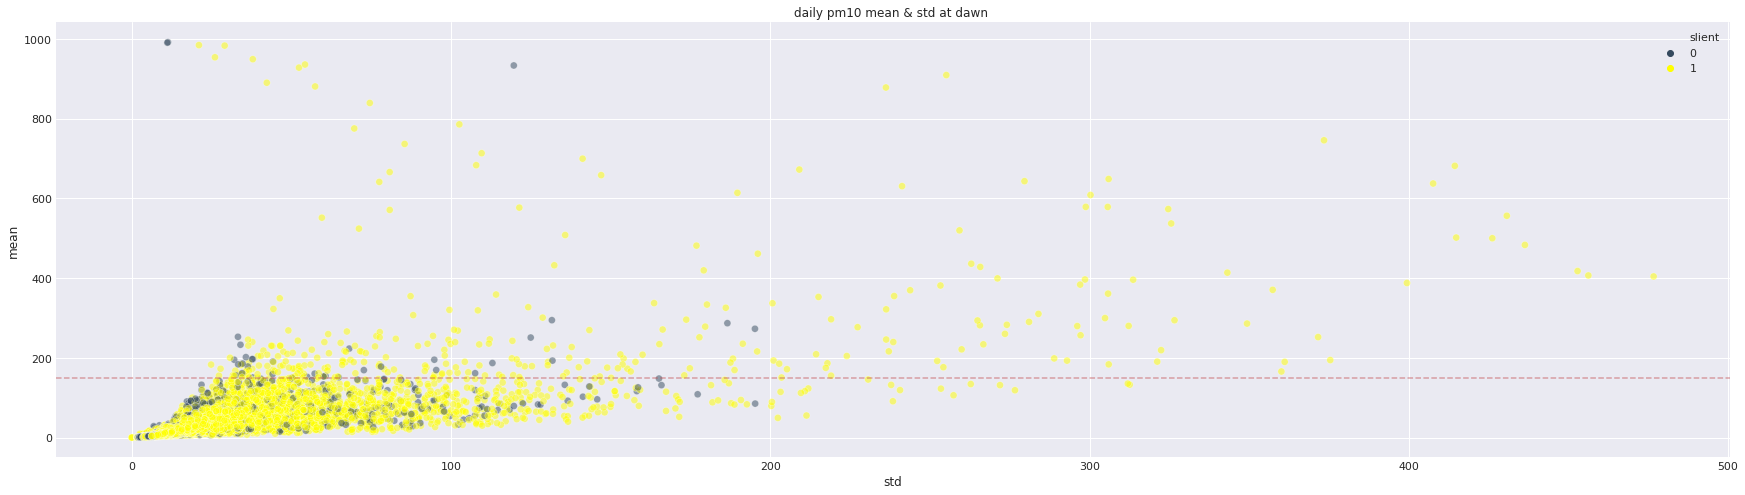

In [200]:
%%time
plt.style.use('seaborn-darkgrid')
kws = dict(s=50, linewidth=.5, edgecolor="w", alpha=.5)

fig = plt.figure(figsize=(30,8))
# Initialize the figure
palette = sns.color_palette()
sns.set_palette(colors)
plt.style.use('seaborn-darkgrid')

ax = sns.scatterplot(x="std", y="mean", hue="slient", legend='full', palette=[palette[0], palette[3]], data=case_I_result, **kws)
plt.title("daily pm10 mean & std at dawn ")
plt.axhline(150,  color='r', linestyle='--', alpha=0.5)
# ax = sns.distplot(case_I_result['std'], bins=100, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
# plt.xlim((startDate, endDate))
# plt.axhline(30,  color='b', linestyle='--', alpha=0.5)
# plt.axhline(150, color='r', linestyle='--', alpha=0.5)
# ticks = ax.get_xticks()
# plt.axvline(ticks[2], color='k', linestyle='--', alpha=0.5)
# plt.axvline(ticks[4], color='k', linestyle='--', alpha=0.5)
# plt.axvline(ticks[6], color='k', linestyle='--', alpha=0.5)

CPU times: user 48 ms, sys: 32 ms, total: 80 ms
Wall time: 41.8 ms


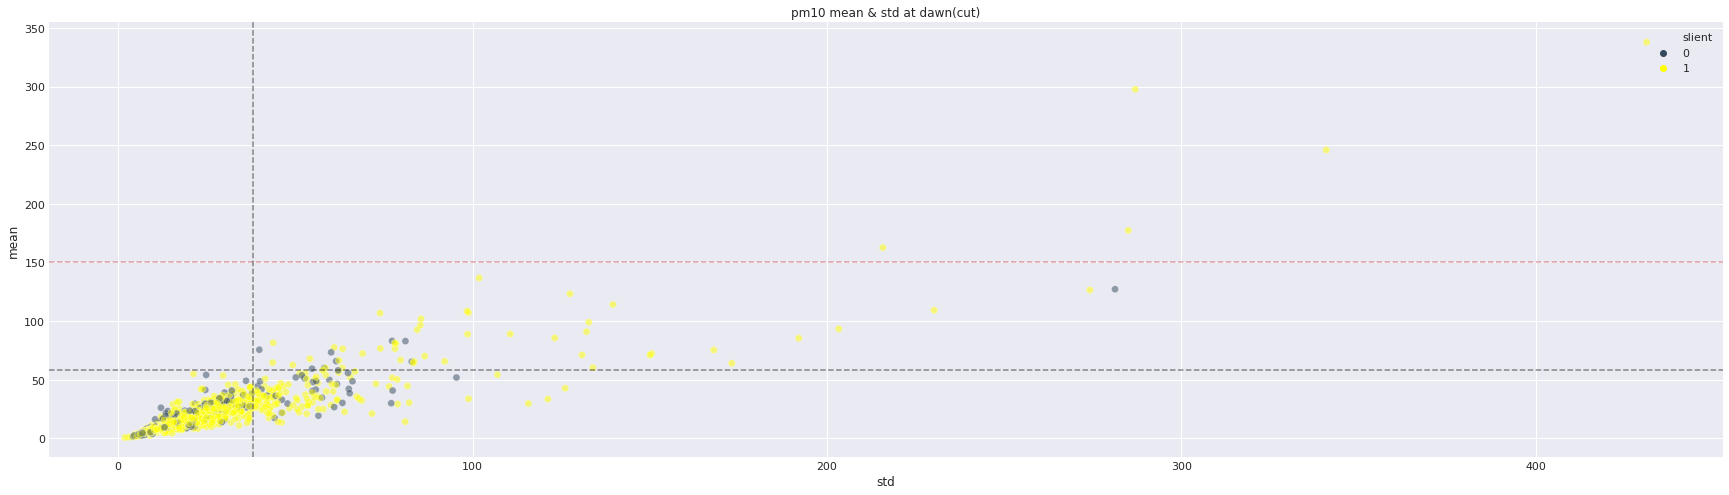

In [204]:
%%time
plt.style.use('seaborn-darkgrid')
kws = dict(s=50, linewidth=.5, edgecolor="w", alpha=.5)

fig = plt.figure(figsize=(30,8))
# Initialize the figure
palette = sns.color_palette()
sns.set_palette(colors)
plt.style.use('seaborn-darkgrid')

ax = sns.scatterplot(x="std", y="mean", hue="slient", legend='full', palette=[palette[0], palette[3]], data=case_I_result_dev, **kws)
plt.title("pm10 mean & std at dawn(cut)")
# ax = sns.distplot(case_I_result['std'], bins=100, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
# plt.xlim((0, 100))
plt.axhline(150,  color='r', linestyle='--', alpha=0.5)
plt.axhline(58.1243,  color='k', linestyle='--', alpha=0.5)
plt.axvline(38.0256, color='k', linestyle='--', alpha=0.5)
# ticks = ax.get_xticks()
# plt.axvline(ticks[2], color='k', linestyle='--', alpha=0.5)
# plt.axvline(ticks[4], color='k', linestyle='--', alpha=0.5)
# plt.axvline(ticks[6], color='k', linestyle='--', alpha=0.5)

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 72.9 ms


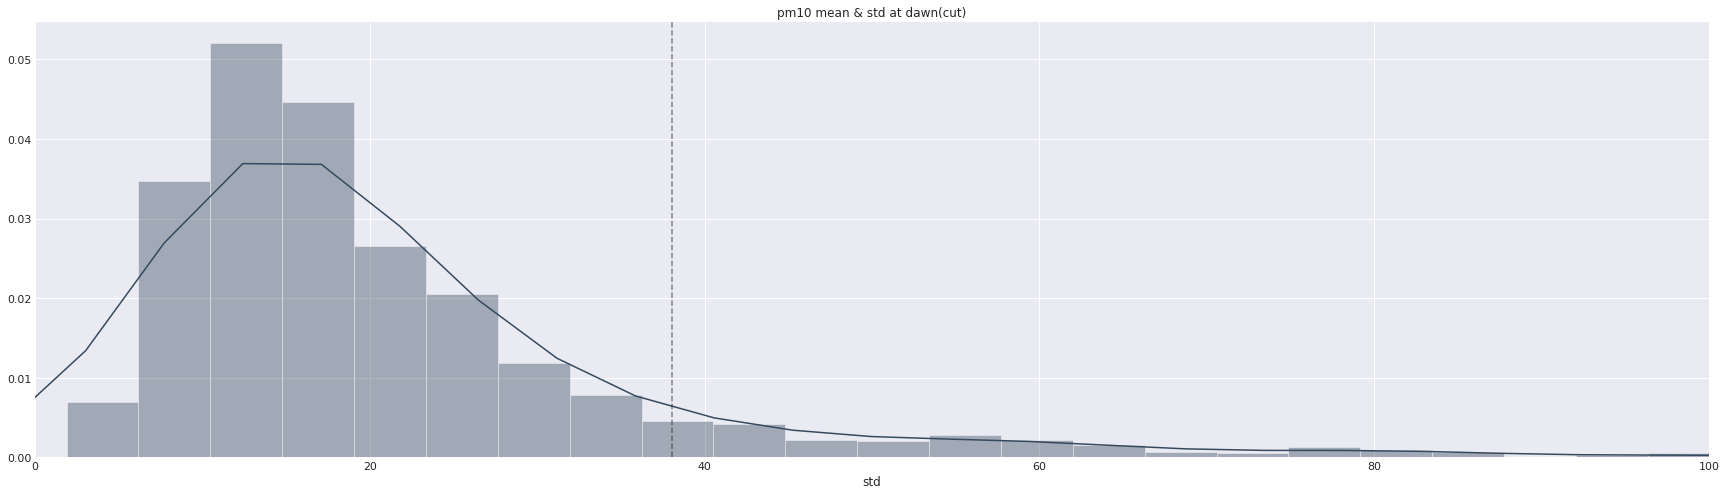

In [203]:
%%time
plt.style.use('seaborn-darkgrid')
kws = dict(s=50, linewidth=.5, edgecolor="w", alpha=.5)

fig = plt.figure(figsize=(30,8))
# Initialize the figure
palette = sns.color_palette()
sns.set_palette(colors)
plt.style.use('seaborn-darkgrid')

# ax = sns.scatterplot(x="std", y="mean", hue="slient", legend='full', palette=[palette[0], palette[3]], data=case_I_result_dev, **kws)
# ax = sns.distplot(case_I_result_dev['std'], bins=100, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
ax = sns.distplot(case_I_result_dev['std'], bins=100)
plt.title("pm10 mean & std at dawn(cut)")
plt.axvline(38.0256, color='k', linestyle='--', alpha=0.5)
plt.xlim((0, 100))
# plt.xlim((startDate, endDate))
# plt.axhline(30,  color='b', linestyle='--', alpha=0.5)
# plt.axhline(150, color='r', linestyle='--', alpha=0.5)
# ticks = ax.get_xticks()
# plt.axvline(ticks[2], color='k', linestyle='--', alpha=0.5)
# plt.axvline(ticks[4], color='k', linestyle='--', alpha=0.5)
# plt.axvline(ticks[6], color='k', linestyle='--', alpha=0.5)

In [47]:
def generate_graph(data, s_date, e_date, path, save=False):
    target_data = data[data['dev_dt'].between(s_date, e_date)]
    if not os.path.exists(path + data['dev_id'].unique()[0]):
        os.makedirs(path + data['dev_id'].unique()[0])
        
    ## graph configure
    colors = ['#34495e','#2ecc71','#3498db','#FFFF33','#e74c3c','#a9a9a9']
    sns.set_palette(colors)
    plt.style.use('seaborn-darkgrid')
    kws = dict(s=20, linewidth=.5, edgecolor="w")
    modes = target_data['mode_stng'].unique()
    modes.sort()
    
    print(data['dev_id'].unique()[0], s_date, e_date)

    fig = plt.figure(figsize=(30,10))
    axe01 = plt.subplot2grid((4,4), (0,0), rowspan = 1, colspan = 4)
    if len(modes) == 1:
        if np.isnan(modes[0]):
            sns.scatterplot(x="dev_dt", y="pm10", palette=colors[-1], data=target_data, legend='full',**kws)
        else:
            sns.scatterplot(x="dev_dt", y="pm10", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="pm10", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
    plt.axhline(30,  color='b', linestyle='--', alpha=0.5)
    plt.axhline(150, color='r', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
    axe01.xaxis.label.set_visible(False)
    axe01.xaxis.set_ticklabels([])
    plt.xlim((s_date, e_date))

    axe02 = plt.subplot2grid((4,4), (1,0), rowspan = 1, colspan = 4)
    if len(modes) == 1:
        if np.isnan(modes[0]):
            sns.scatterplot(x="dev_dt", y="co2", palette=colors[-1], data=target_data, legend='full',**kws)
        else:
            sns.scatterplot(x="dev_dt", y="co2", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="co2", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
    plt.axhline(600,  color='b', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
    axe02.xaxis.label.set_visible(False)
    axe02.xaxis.set_ticklabels([])
    plt.xlim((s_date, e_date))

    axe03 = plt.subplot2grid((4,4), (2,0), rowspan = 1, colspan = 4)
    if len(modes) == 1:
        if np.isnan(modes[0]):
            sns.scatterplot(x="dev_dt", y="lux", palette=colors[-1], data=target_data, legend='full',**kws)
        else:
            sns.scatterplot(x="dev_dt", y="lux", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="lux", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
    axe03.xaxis.label.set_visible(False)
    axe03.xaxis.set_ticklabels([])
    plt.xlim((s_date, e_date))

    axe04 = plt.subplot2grid((4,4), (3,0), rowspan = 1, colspan = 4)
    if len(modes) == 1:
        if np.isnan(modes[0]):
            sns.scatterplot(x="dev_dt", y="fan_speed_adj", palette=colors[-1], data=target_data, legend='full',**kws)
        else:
            sns.scatterplot(x="dev_dt", y="fan_speed_adj", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="fan_speed_adj", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
    plt.xlim((s_date, e_date))
    axe04.set_yticks([0, 1, 2, 3])
    
    plt.tight_layout()
    if save:
        fig.savefig(path + data['dev_id'].unique()[0] + '/' + s_date.strftime('%Y%m%d') +'.png')
        plt.close('all')